In [1]:
pip install torch-geometric


Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install lpips


Note: you may need to restart the kernel to use updated packages.


In [3]:
import lpips

In [16]:
# === PyTorch Core ===
import torch  # Core PyTorch library for tensors and GPU support
import torch.nn as nn  # Neural network modules
import torch.nn.functional as F  # Functional API (activations, loss functions, etc.)

# === Scientific Computing ===
import numpy as np  # Array and numerical computations
import networkx as nx
import h5py  # Reading HDF5 files (commonly used in physics datasets)
from scipy.spatial import cKDTree  # Fast nearest-neighbor search (used for graph construction)
from scipy.sparse import coo_matrix  # Sparse matrix format (efficient graph representation)
from skimage.transform import resize  # Image resizing utility (e.g., 64x64 to 32x32)

# === Plotting & Visualization ===
import matplotlib.pyplot as plt  # Visualization library for plotting data/images

# === Dataset & Dataloader Utilities ===
from torch.utils.data import Dataset, DataLoader, random_split  # Data handling and batching

# === PyTorch Geometric (Graph Neural Networks) ===
from torch_geometric.data import Data, Batch  # Graph data structures and batching
from torch_geometric.nn import GCNConv  # Graph Convolutional Network layer

# === Diffusers (Hugging Face) ===
from diffusers import UNet2DModel, DDPMScheduler  # Diffusion model architecture and scheduler

# === Accelerator ===
from accelerate import Accelerator  # Simplifies multi-GPU training and mixed precision

# === Progress Bar ===
from tqdm import tqdm  # Progress bar for training/testing loops

In [5]:
# Check if CUDA (GPU) is available; otherwise, default to CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.empty_cache()
print(f"Using device: {device}")
file_path = "/kaggle/input/autoencoder-data/quark-gluon_data-set_n139306.hdf5"

Using device: cuda


In [6]:
def explore_hdf5(file):
    with h5py.File(file, "r") as f:
        print("Keys in dataset:", list(f.keys()))
        for key in f.keys():
            print(f"Shape of {key}: {f[key].shape}")

explore_hdf5(file_path)

Keys in dataset: ['X_jets', 'm0', 'pt', 'y']
Shape of X_jets: (139306, 125, 125, 3)
Shape of m0: (139306,)
Shape of pt: (139306,)
Shape of y: (139306,)


In [7]:
def load_data(file_path, sample_size):
    with h5py.File(file_path, 'r') as f:
        X = np.array(f['X_jets'][:sample_size])  # Shape (N, 125, 125, 3)
        y = np.array(f['y'][:sample_size], dtype=np.int64)
    return X, y

# Load 10,000 samples from the dataset
X, y = load_data(file_path, 10000)

In [8]:
def preprocess_images(images):
    """Resize and normalize images, returning numpy array"""
    # Resize to 128x128 and normalize
    processed = np.array([resize(img, (128, 128), anti_aliasing=True) for img in images], dtype=np.float32)
    # Compute mean and standard deviation for normalization
    mean, std = np.mean(processed), np.std(processed)
    # Normalize: (X - mean) / std, and clip negative values to 0
    return np.clip((processed - mean) / std, 0, None)  # Shape (N, 128, 128, 3)

X_processed = preprocess_images(X)  # (N, 128, 128, 3) numpy array

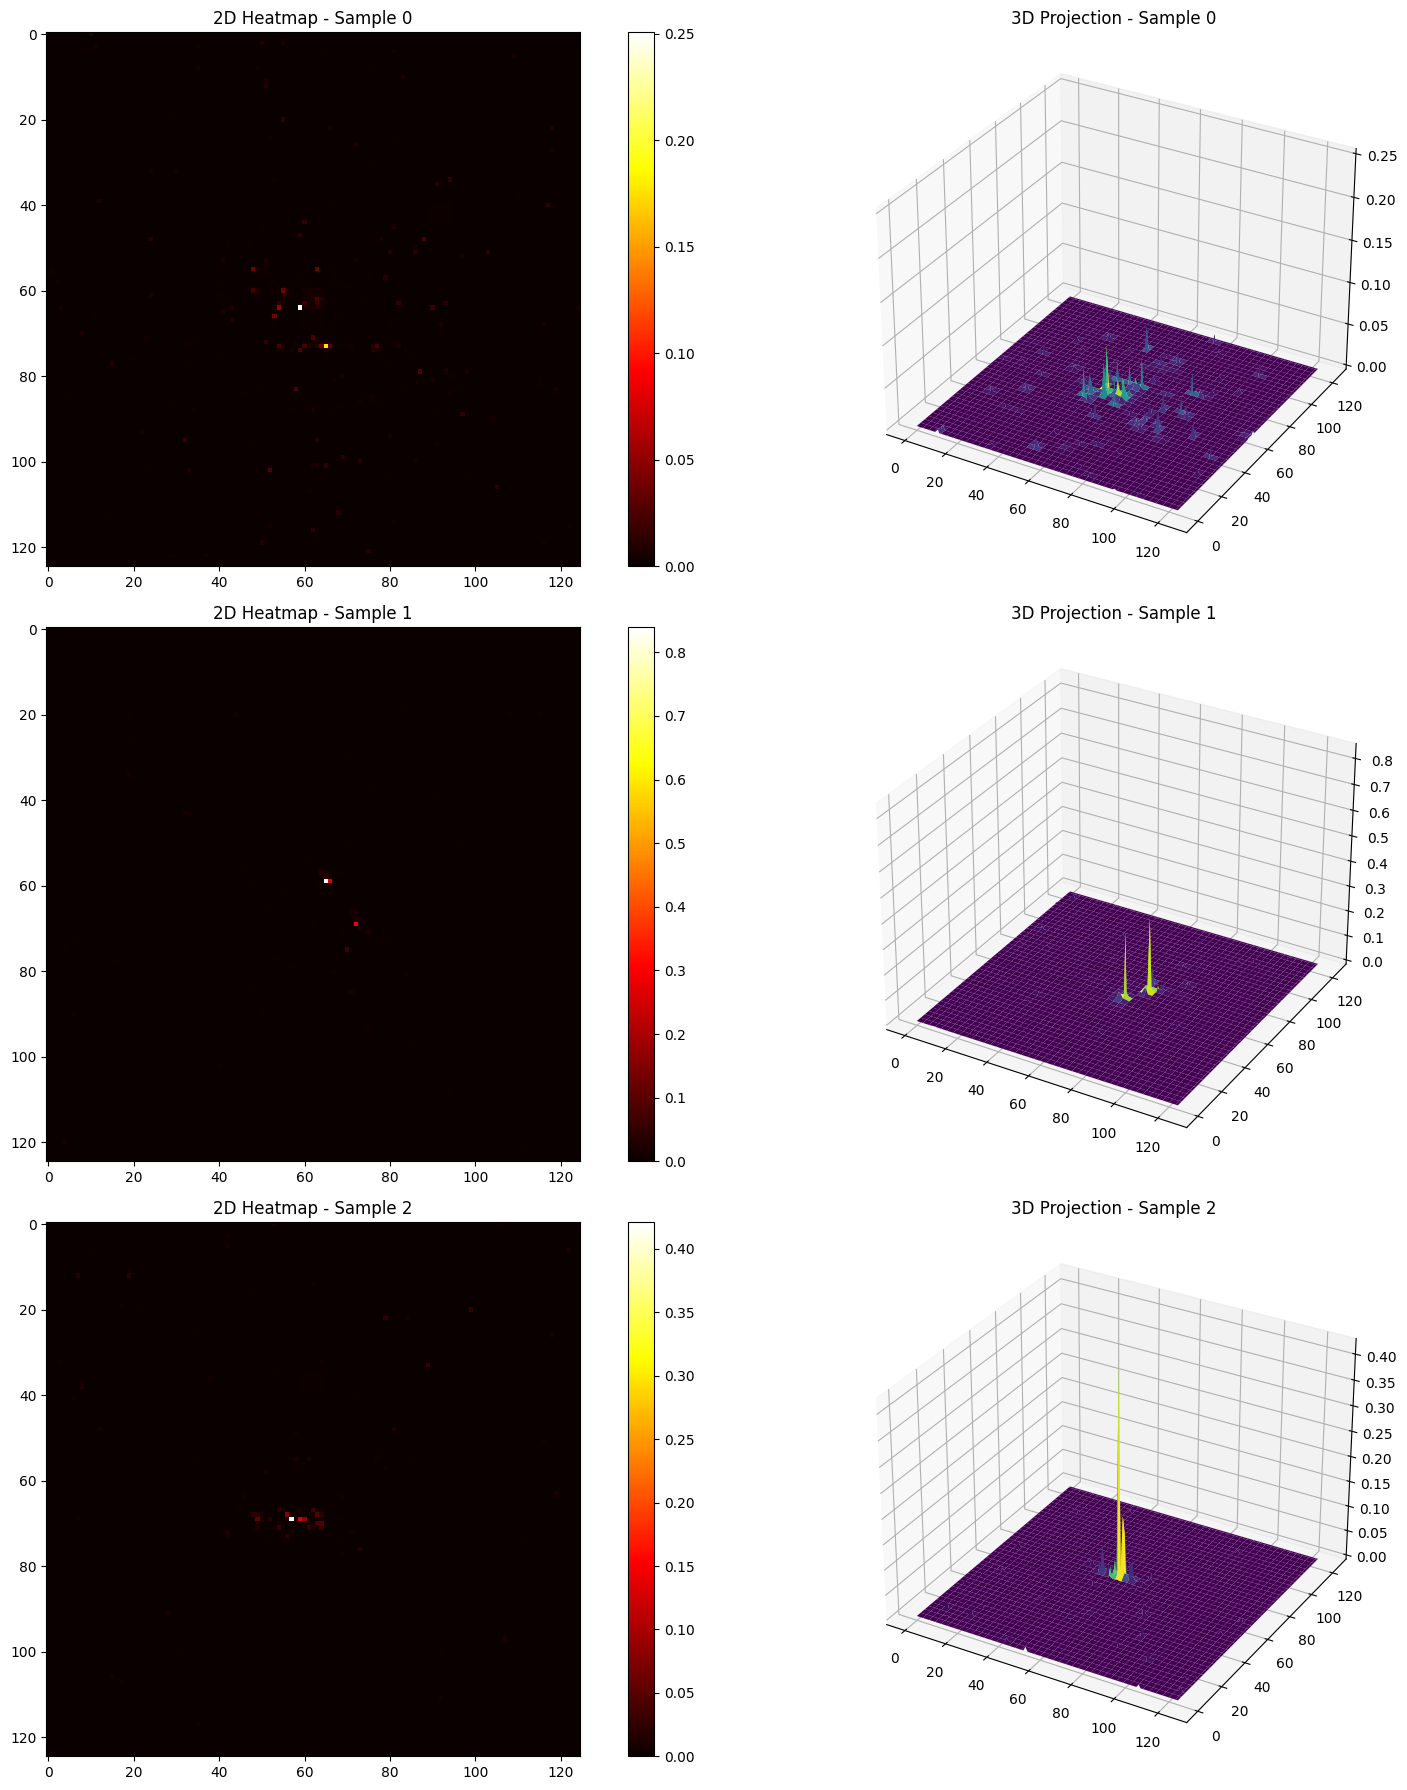

In [9]:
def heatmap_with_projection(images, num_samples=3):
    fig = plt.figure(figsize=(18, 6 * num_samples))
    
    for idx in range(num_samples):
        # 2D Heatmap
        ax1 = fig.add_subplot(num_samples, 2, 2*idx + 1)
        combined_data = np.sum(images[idx], axis=-1)
        heatmap = ax1.imshow(combined_data, cmap='hot', interpolation='nearest')
        plt.colorbar(heatmap, ax=ax1)
        ax1.set_title(f'2D Heatmap - Sample {idx}')
        
        # 3D Projection
        ax2 = fig.add_subplot(num_samples, 2, 2*idx + 2, projection='3d')
        X, Y = np.meshgrid(np.arange(combined_data.shape[1]), np.arange(combined_data.shape[0]))
        ax2.plot_surface(X, Y, combined_data, cmap='viridis')
        ax2.set_title(f'3D Projection - Sample {idx}')
    
    plt.tight_layout()
    plt.show()

heatmap_with_projection(X)

In [10]:
def extract_nonzero_mask(images):
    """Create mask for non-zero pixels (images: numpy array)"""
    # Reshape the images array to combine height and width dimensions while keeping the 3 channels (Track, ECAL, HCAL)
    reshaped = images.reshape((-1, images.shape[1] * images.shape[2], 3))
    # Check if any channel in each pixel has nonzero values (i.e., meaningful data) and create a binary mask
    # axis=-1 ensures the check is applied along the 3 channels (Track, ECAL, HCAL)
    return np.any(reshaped != 0, axis=-1).reshape(images.shape[:3])# Restore the original shape

mask = extract_nonzero_mask(X_processed)

In [11]:
def create_graph_features(images, mask):
    """Extract node features and coordinates"""
    indices, features = [], [] # Initialize lists to store the indices (coordinates) and features (pixel values)
    # Iterate through each image and its corresponding mask
    for img_idx in range(len(mask)):
        # Get the coordinates (row, column) of non-zero pixels (True pixels in the mask)
        coords = np.column_stack(np.where(mask[img_idx]))

        # Extract the feature (pixel values) for the corresponding coordinates in the image
        # `coords[:, 0]` gives the row indices, and `coords[:, 1]` gives the column indices
        features.append(images[img_idx][mask[img_idx]]) # Collect feature values (Track, ECAL, HCAL)
        # Store the coordinates of the non-zero pixels as graph nodes
        indices.append(coords)
    return indices, features

indices_list, features_list = create_graph_features(X_processed, mask)


In [12]:
def build_graph_structure(coords, k=4):
    """Build adjacency matrix for graph"""
    # Create a k-d tree from the coordinates to efficiently find the k nearest neighbors
    tree = cKDTree(coords)

    # Query the k nearest neighbors for each point (coordinates)
    # dist contains the distances to the k nearest neighbors, indices contains their indices
    dist, indices = tree.query(coords, k=k)
    # Compute the variance of the distance of the k-th nearest neighbor (to use as a scaling factor for the kernel)
    sigma2 = np.mean(dist[:, -1])**2
    # Compute the weights for the edges based on the Gaussian kernel (exponent of negative squared distance / sigma^2)
    weights = np.exp(-dist**2 / sigma2)
    # Create the row and column indices for the sparse adjacency matrix
    # Repeat the index for each neighbor and flatten the indices array for the coo_matrix
    row, col = np.arange(len(coords)).repeat(k), indices.flatten()

    # Return the sparse adjacency matrix in COO format
    return coo_matrix((weights.flatten(), (row, col)), 
                      shape=(len(coords), len(coords)))

In [13]:
def create_graph_dataset(indices_list, features_list, labels, neighbors=8):
    """Create list of PyG Data objects"""
    dataset = []
    # Loop over each sample in the indices list
    for i, points in enumerate(indices_list):
        # Build the graph structure using k-nearest neighbors (k=neighbors)
        adjacency = build_graph_structure(points, k=neighbors)
        # Convert the adjacency matrix row and column indices to a PyTorch tensor
        # These represent the edges of the graph
        edge_idx = torch.from_numpy(np.vstack((adjacency.row, adjacency.col))).long()
        # Convert the edge weights to a PyTorch tensor
        edge_weights = torch.from_numpy(adjacency.data).float().view(-1, 1)
        node_features = torch.from_numpy(features_list[i]).float()
        # Convert the label for the current graph to a PyTorch tensor
        label = torch.tensor([int(labels[i])], dtype=torch.long)
        # Add the created graph object to the dataset
        dataset.append(Data(x=node_features, edge_index=edge_idx, 
                          edge_attr=edge_weights, y=label))
    return dataset

In [14]:
# Create the graph dataset by calling the create_graph_dataset function
# The function takes in:
# - indices_list: List of indices representing the coordinates of the non-zero points in the images
# - y: The labels corresponding to each image in the dataset
# - neighbors: The number of nearest neighbors (k) to consider when building the graph structure (set to 8)
graph_data = create_graph_dataset(indices_list, features_list, y)

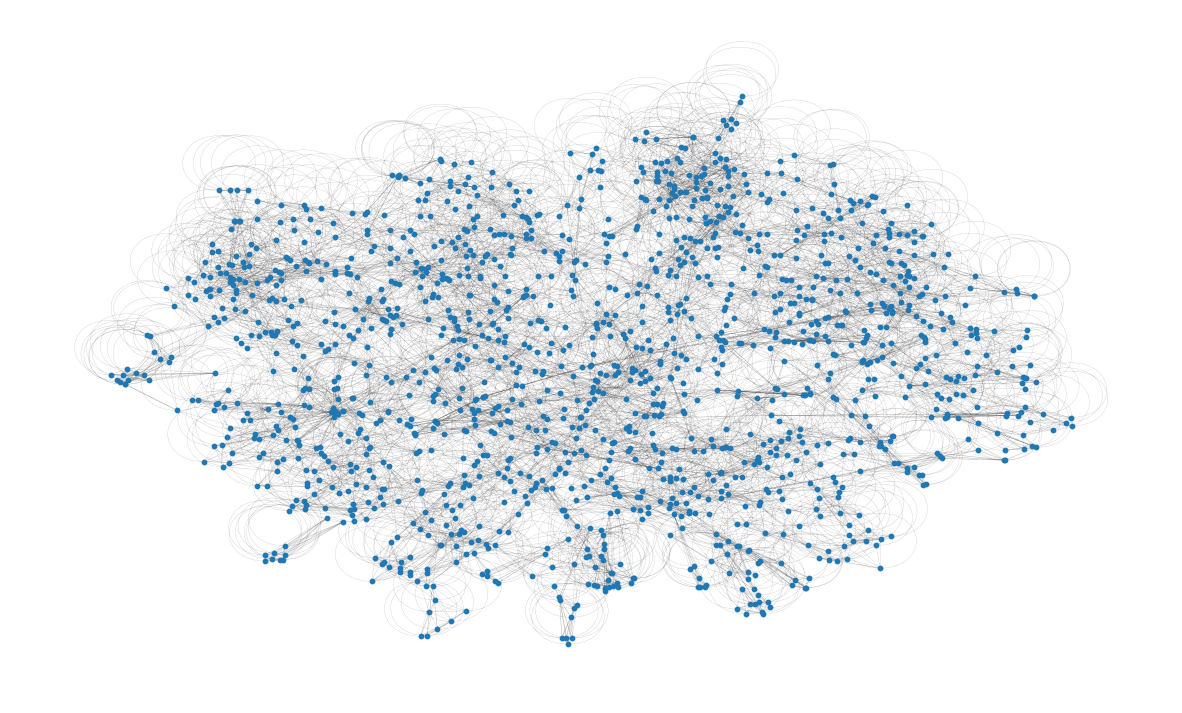

Number of graphs to work upon : 10000
For the FIRST graph in the graph dataset : 
Type of each graph entity data object: <class 'torch_geometric.data.data.Data'>
Number of nodes: 1530
Number of edges: 12240
Number of node features: 3
Number of edges features: 1


In [17]:
# Initialize an empty NetworkX graph
G = nx.Graph()

# Extract the first graph from the graph dataset
data = graph_data[0]

# Get the edge index tensor from the data object, which contains information about the graph edges
edge_tensor = data.edge_index

# Convert the edge index tensor into a list of edge tuples (node1, node2) for NetworkX
edge_list = [(edge_tensor[0, i].item(), edge_tensor[1, i].item()) for i in range(edge_tensor.shape[1])]

# Add the edges to the NetworkX graph G
G.add_edges_from(edge_list)

# Create a layout for the nodes of the graph using the spring layout (force-directed layout)
pos = nx.spring_layout(G, iterations=15, seed=1721)

# Plot the graph
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
nx.draw_networkx(G, pos=pos, ax=ax, node_size=10, with_labels=False, width=0.05)
plt.show()

# Print the number of graphs in the graph dataset
print(f'Number of graphs to work upon : {len(graph_data)}')

# Print information about the first graph in the graph dataset
print(f'For the FIRST graph in the graph dataset : ')
print(f'Type of each graph entity data object: {type(data)}')
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Number of node features: {data.num_node_features}')
print(f'Number of edges features: {data.num_edge_features}')

In [18]:
class JetGraphDataset(Dataset):
    # Dataset class that pairs graph data with corresponding image data
    # Combines graph representations (PyG Data objects) with image data
    # Used for joint processing in graph+image machine learning models
    def __init__(self, graph_data, image_data):
        # Initialize dataset with graph and image data
        #
        # Args:
        #   graph_data: List of PyTorch Geometric Data objects (graphs)
        #   image_data: Numpy array of corresponding images (will be normalized)
        #
        # Raises:
        #   AssertionError if graph and image counts don't match
        
        # Verify equal number of graphs and images
        assert len(graph_data) == len(image_data), "Graph and image dataset lengths must match"
        # Store graph data (list of PyG Data objects)
        self.graph_data = graph_data  

        # Convert images to tensor and normalize to [0,1] range
        # Input should be uint8 (0-255) -> becomes float32 (0.0-1.0)
        self.image_data = torch.from_numpy(image_data).float() / 255.0  # Normalize to [0, 1]
        
    def __len__(self):
        # Get total number of samples in dataset
        # Returns:
        #   int: Count of graph-image pairs
        return len(self.graph_data)
    
    def __getitem__(self, idx):
        # Get single graph-image pair by index
        #
        # Args:
        #   idx: Integer index of sample to retrieve
        #
        # Returns:
        #   tuple: (graph_data, image_tensor) where:
        #     - graph_data: PyG Data object at index idx
        #     - image_tensor: Normalized float32 image tensor
        return self.graph_data[idx], self.image_data[idx]


def collate_graphs(batch):
    """
    Custom collate function to batch (graph, image) pairs.
    Converts list of PyG Data objects into a PyG Batch.
    Ensures images are in (N, C, H, W) format.
    """
    graphs = [item[0] for item in batch]
    images = torch.stack([item[1] for item in batch])  # (N, H, W, C) if using PNGs or converted RGB

    if images.dim() == 4 and images.shape[-1] == 3:
        # Convert from (N, H, W, C) to (N, C, H, W)
        images = images.permute(0, 3, 1, 2)

    return Batch.from_data_list(graphs), images

In [19]:
# Create joint dataset
joint_dataset = JetGraphDataset(graph_data, X_processed)

In [20]:
class GraphEncoder(nn.Module):
    """Graph Convolutional Network (GCN) based encoder for graph data.
    Transforms node features through successive graph convolutional layers."""
    def __init__(self, in_channels, out_channels):
        """
        Args:
            in_channels: Number of input features per node
            out_channels: Number of output features per node
        """
        super().__init__()
        # Three GCN layers with decreasing hidden dimensions
        self.conv1 = GCNConv(in_channels, 128)
        self.conv2 = GCNConv(128, 64)
        self.conv3 = GCNConv(64, out_channels)
        
    def forward(self, x, edge_index, edge_attr=None):
        """Forward pass through the encoder.
        
        Args:
            x: Node feature matrix [num_nodes, in_channels]
            edge_index: Graph connectivity [2, num_edges]
            edge_attr: Optional edge features [num_edges, edge_dim]
            
        Returns:
            Encoded node features [num_nodes, out_channels]
        """
        x = F.relu(self.conv1(x, edge_index, edge_attr))
        x = F.relu(self.conv2(x, edge_index, edge_attr))
        return self.conv3(x, edge_index, edge_attr)

class GraphDecoder(nn.Module):
    """Simple MLP-based decoder for graph reconstruction.
    Reconstructs adjacency matrix from node embeddings."""
    def __init__(self, in_channels):
        """
        Args:
            in_channels: Dimension of input node embeddings
        """
        super().__init__()
        # Two linear layers for decoding
        self.lin1 = nn.Linear(in_channels, 64)
        self.lin2 = nn.Linear(64, 128)
        
    def forward(self, z):
        """Forward pass through the decoder.
        
        Args:
            z: Node embeddings [num_nodes, in_channels]
            
        Returns:
            Reconstructed adjacency matrix [num_nodes, num_nodes] (sigmoid activated)
        """
        z = F.relu(self.lin1(z))# First linear layer + ReLU
        # Outer product reconstruction with sigmoid activation
        return torch.sigmoid(self.lin2(z) @ self.lin2(z).t())

In [21]:
class GraphImageDenoiser(nn.Module):
    """Joint graph-image denoising model combining:
    - Graph autoencoder for graph structure learning
    - Diffusion model for image denoising
    - Contrastive loss for graph learning
    """
    def __init__(self, latent_dim=32):
        """
        Args:
            latent_dim: Dimension of graph node embeddings
        """
        super().__init__()
        # Graph components
        self.encoder = GraphEncoder(3, latent_dim)
        self.decoder = GraphDecoder(latent_dim)
        
        self.ddpm = UNet2DModel(
            sample_size=128,
            in_channels=3,
            out_channels=3,
            layers_per_block=2,
            block_out_channels=(64, 128, 256, 512),
            down_block_types=("DownBlock2D",)*3 + ("AttnDownBlock2D",),
            up_block_types=("AttnUpBlock2D",) + ("UpBlock2D",)*3
        )
        self.scheduler = DDPMScheduler(num_train_timesteps=1000)
        self.loss_fn_alex = lpips.LPIPS(net='alex').to(device).eval()  # LPIPS perceptual loss
        self.loss_fn_vgg = lpips.LPIPS(net='vgg').to(device).eval()  # Deeper network for style
        self.to(device)


    def charbonnier_loss(self, pred, target, eps=1e-3):
        """Robust Charbonnier loss for image reconstruction.
        Less sensitive to outliers than MSE.
        
        Args:
            pred: Predicted image tensor
            target: Ground truth image tensor
            eps: Small constant for numerical stability
            
        Returns:
            Charbonnier loss value
        """
        return torch.mean(torch.sqrt((pred - target) ** 2 + eps ** 2))

    
    def forward(self, batch, images):
        """Joint forward pass for graph and image processing.
        
        Args:
            batch: PyG batch object containing graph data
            images: Tensor of input images [B, C, H, W]
            
        Returns:
            denoised_pred: Denoised image predictions
            ddpm_loss: Diffusion model loss
            recon_loss: Graph contrastive loss
        """
        # Graph encoding
        z_nodes = self.encoder(batch.x, batch.edge_index, batch.edge_attr)
        z_nodes = F.normalize(z_nodes, p=2, dim=-1)

        # Image denoising
        noise = torch.randn_like(images)
        timesteps = torch.randint(0, 1000, (images.size(0),), device=device).long()
        noisy_images = self.scheduler.add_noise(images, noise, timesteps)
        denoised_pred = self.ddpm(noisy_images, timesteps).sample

        # Charbonnier loss for denoising
        ddpm_loss = self.charbonnier_loss(denoised_pred, images)

        # Graph contrastive loss
        recon_loss = self.contrastive_graph_loss(z_nodes, batch.edge_index)

        return denoised_pred, ddpm_loss, recon_loss

    def contrastive_graph_loss(self, z_nodes, edge_index, margin=1.0):
        """Contrastive loss for graph embeddings.
        Pulls connected nodes together, pushes random pairs apart.
        
        Args:
            z_nodes: Node embeddings [num_nodes, latent_dim]
            edge_index: Graph connectivity [2, num_edges]
            margin: Margin for contrastive loss
            
        Returns:
            Contrastive loss value
        """
        src, dst = edge_index
        # Positive pairs (connected nodes)
        pos_sim = F.cosine_similarity(z_nodes[src], z_nodes[dst], dim=1)
        # Negative pairs (random nodes)
        num_nodes = z_nodes.size(0)
        rand_src = torch.randint(0, num_nodes, (len(src),), device=z_nodes.device)
        rand_dst = torch.randint(0, num_nodes, (len(dst),), device=z_nodes.device)
        neg_sim = F.cosine_similarity(z_nodes[rand_src], z_nodes[rand_dst], dim=1)
        # Contrastive loss with margin
        loss = F.relu(margin - pos_sim + neg_sim).mean()
        return loss

In [22]:
def train_model(model, train_loader, val_loader, epochs=5):
    """Train the GraphImageDenoiser model with validation monitoring.
    
    Args:
        model: GraphImageDenoiser model instance
        train_loader: DataLoader for training data
        val_loader: DataLoader for validation data
        epochs: Number of training epochs (default: 5)
        
    Returns:
        train_losses: List of average training losses per epoch
        val_losses: List of average validation losses per epoch
    """
    # Initialize optimizer with AdamW (improved weight decay handling)
    optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4)

    # Set up Hugging Face Accelerator for hardware optimization
    accelerator = Accelerator()
    model, optimizer, train_loader, val_loader = accelerator.prepare(
        model, optimizer, train_loader, val_loader
    )

    # Loss tracking
    train_losses = []
    val_losses = []

    # Training loop
    for epoch in range(epochs):
        model.train()
        train_loss = 0

        # Batch processing with progress bar
        for batch, images in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            optimizer.zero_grad()

            # Forward pass - returns (denoised_pred, ddpm_loss, recon_loss)
            _, ddpm_loss, recon_loss = model(batch, images)
            # Combined loss (image denoising + graph reconstruction)
            loss = ddpm_loss + recon_loss
            # Safety check for numerical stability
            if loss.item() < 0:
                print("Warning: Negative loss detected", loss.item())
            # Backpropagation with accelerator for mixed precision/GPU support
            accelerator.backward(loss)
            # Update parameters
            optimizer.step()
            # Accumulate loss (note: loss.item() converts to Python float)
            train_loss += loss.item()
        
        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():   # Disable gradient computation
            for batch, images in val_loader:
                # Forward pass (only compute loss, no gradients)
                _, ddpm_loss, recon_loss = model(batch, images)
                val_loss += (ddpm_loss + recon_loss).item()
        
        # Calculate epoch averages
        avg_train_loss = train_loss/len(train_loader)
        avg_val_loss = val_loss/len(val_loader)
        # Store for later analysis
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        # Progress reporting
        print(f"Epoch {epoch+1} | Train Loss: {train_loss/len(train_loader):.4f} | "
              f"Val Loss: {val_loss/len(val_loader):.4f}")

    return train_losses, val_losses

In [25]:
if __name__ == "__main__":
    """Main execution block for training the GraphImageDenoiser model."""
    
    # Dataset splitting with reproducible random seed
    train_size = int(0.8 * len(joint_dataset))
    # Split dataset using fixed random seed for reproducibility
    train_set, val_set = random_split(joint_dataset, [train_size, len(joint_dataset)-train_size],
                                    generator=torch.Generator().manual_seed(42))
    
    # Create training DataLoader with:
    # - Batch size of 16
    # - Shuffling enabled (only for training)
    # - Custom collate function for graph data
    # - Pinned memory for faster GPU transfer
    train_loader = DataLoader(train_set, batch_size=16, shuffle=True, 
                            collate_fn=collate_graphs, pin_memory=True)
    # Create validation DataLoader (no shuffling needed)
    val_loader = DataLoader(val_set, batch_size=16, 
                          collate_fn=collate_graphs, pin_memory=True)
    
    # Initialize model and move to appropriate device (GPU)
    model = GraphImageDenoiser().to(device)
    # Train model and get loss histories
    train_losses, val_losses = train_model(model, train_loader, val_loader)
    
    # Save model weights to file
    model_save_path = "/kaggle/working/trained_model_weights.pth"
    torch.save(model.state_dict(), model_save_path)
    print(f"Model weights saved to {model_save_path}")

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 202MB/s]  


Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/usr/local/lib/python3.10/dist-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_location='cpu'), st

Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/vgg.pth


Epoch 1/5: 100%|██████████| 500/500 [04:45<00:00,  1.75it/s]


Epoch 1 | Train Loss: 0.2349 | Val Loss: 0.1920


Epoch 2/5: 100%|██████████| 500/500 [04:43<00:00,  1.76it/s]


Epoch 2 | Train Loss: 0.1917 | Val Loss: 0.1837


Epoch 3/5: 100%|██████████| 500/500 [04:43<00:00,  1.76it/s]


Epoch 3 | Train Loss: 0.1794 | Val Loss: 0.1766


Epoch 4/5: 100%|██████████| 500/500 [04:43<00:00,  1.76it/s]


Epoch 4 | Train Loss: 0.1748 | Val Loss: 0.1732


Epoch 5/5: 100%|██████████| 500/500 [04:43<00:00,  1.76it/s]


Epoch 5 | Train Loss: 0.1726 | Val Loss: 0.1719
Model weights saved to /kaggle/working/trained_model_weights.pth


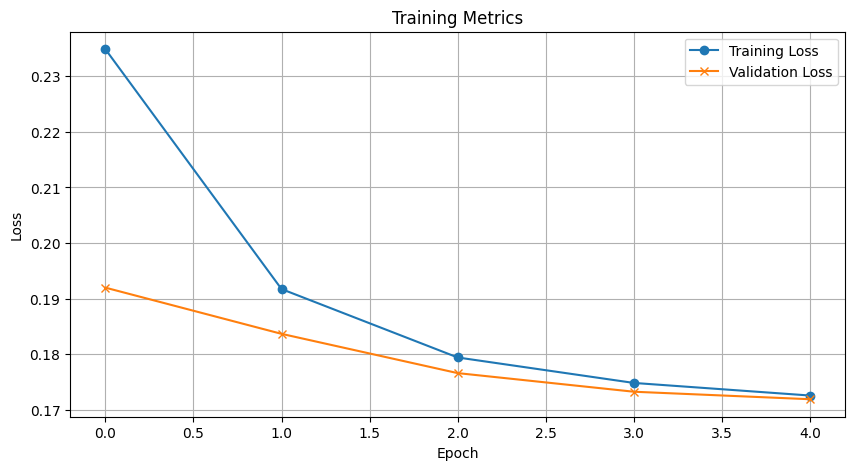

In [26]:
# Plot training and validation loss curves
plt.figure(figsize=(10, 5))  # Set the figure size

# Plot training loss
plt.plot(train_losses, marker='o', linestyle='-', label='Training Loss')

# Plot validation loss
plt.plot(val_losses, marker='x', linestyle='-', label='Validation Loss')

# Add title and axis labels
plt.title('Training Metrics')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Show legend and grid for clarity
plt.legend()
plt.grid(True)

# Save the plot to a file
plt.savefig("training_metrics.png")

# Display the plot
plt.show()

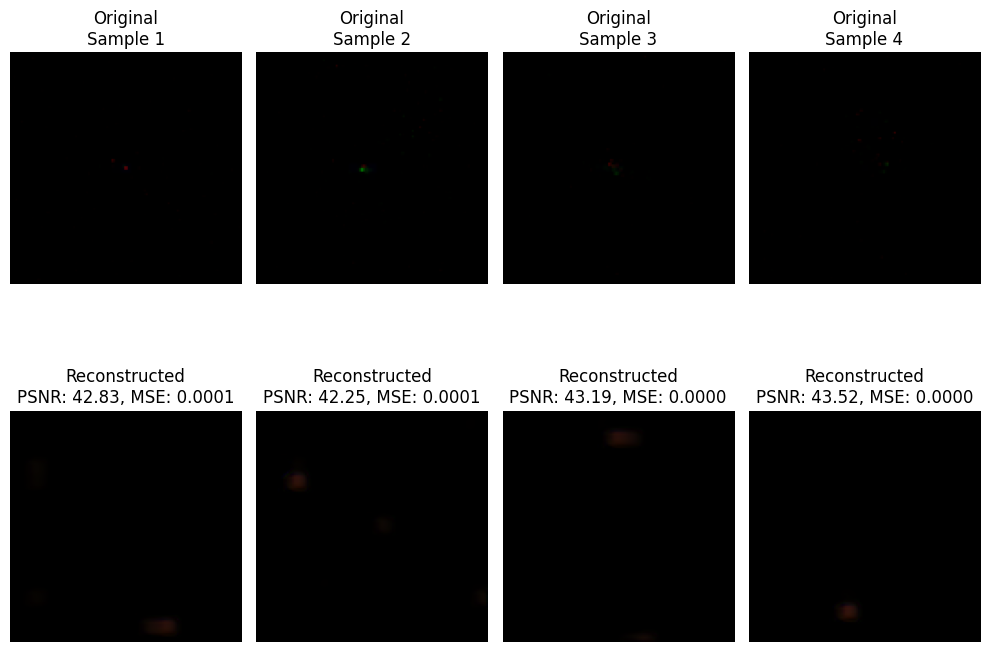

In [27]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid
from skimage.metrics import peak_signal_noise_ratio, mean_squared_error

def tensor_to_imshow(image_tensor):
    image = image_tensor.cpu().numpy()
    if len(image.shape) == 3 and image.shape[0] == 3:  # (C, H, W)
        image = np.transpose(image, (1, 2, 0))  # (H, W, C)
    image = np.clip(image, 0, 1)  # Ensure valid pixel range
    return image

# Get a batch of test data
model.eval()
batch, images = next(iter(val_loader))
batch, images = batch.to(device), images.to(device)

# Generate denoised images
with torch.no_grad():
    denoised, _, _ = model(batch, images)

# Select samples to visualize
num_samples = 4
indices = torch.randperm(images.size(0))[:num_samples]
original_images = images[indices]
reconstructed_images = denoised[indices]

# Calculate metrics for each sample
psnrs = []
mses = []
for orig, recon in zip(original_images, reconstructed_images):
    orig_np = tensor_to_imshow(orig)
    recon_np = tensor_to_imshow(recon)
    psnrs.append(peak_signal_noise_ratio(orig_np, recon_np, data_range=1))
    mses.append(mean_squared_error(orig_np, recon_np))

# Plot comparison
plt.figure(figsize=(10, 8))
for i in range(num_samples):
    # Original Image
    plt.subplot(2, num_samples, i + 1)
    plt.imshow(tensor_to_imshow(original_images[i]))
    plt.title(f"Original\nSample {i+1}")
    plt.axis('off')
    
    # Reconstructed Image with metrics
    plt.subplot(2, num_samples, i + num_samples + 1)
    plt.imshow(tensor_to_imshow(reconstructed_images[i]))
    plt.title(f"Reconstructed\nPSNR: {psnrs[i]:.2f}, MSE: {mses[i]:.4f}")
    plt.axis('off')

plt.tight_layout()
plt.show()

Average Metrics Across Samples:
PSNR: 42.95 ± 0.47
MSE: 0.0001 ± 0.0000


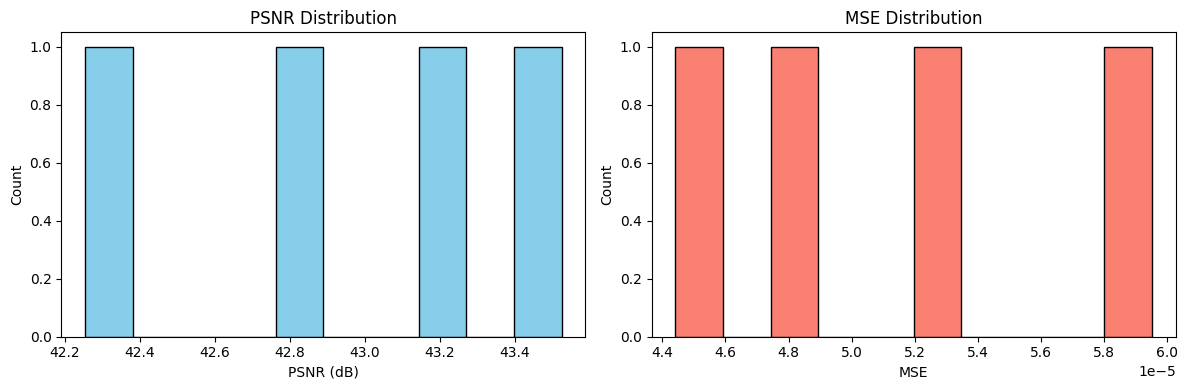

In [28]:
# Print summary statistics of evaluation metrics
print("Average Metrics Across Samples:")
print(f"PSNR: {np.mean(psnrs):.2f} ± {np.std(psnrs):.2f}")
print(f"MSE: {np.mean(mses):.4f} ± {np.std(mses):.4f}")

# Create figure for metric distributions
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(psnrs, bins=10, color='skyblue', edgecolor='black')
plt.title('PSNR Distribution')
plt.xlabel('PSNR (dB)')
plt.ylabel('Count')

# MSE Distribution Plot (Right Subplot)
plt.subplot(1, 2, 2)
plt.hist(mses, bins=10, color='salmon', edgecolor='black')
plt.title('MSE Distribution')
plt.xlabel('MSE')
plt.ylabel('Count')

plt.tight_layout()
plt.show()